In [116]:
import yaml
import json

mapper = yaml.safe_load(open('plot_mapper.yml'))
models = yaml.safe_load(open('../score.yml'))['models']
lang_fam_map = mapper['lang_family_dict']
lang_list = list(lang_fam_map.keys())

model_name_map = mapper['model_name_dict']

ACCURACY_MC_PATH = '../json/{model}_accuracy_mc.json'
ACCURACY_OE_PATH = '../json/{model}_accuracy_oe.json'
BERTSCORE_PATH = '../json/{model}_bertscore_oe.json'

In [117]:
d = []

for model in models:
    acc_mc = json.load(open(ACCURACY_MC_PATH.format(model=model)))
    acc_oe = json.load(open(ACCURACY_OE_PATH.format(model=model)))
    bert = json.load(open(BERTSCORE_PATH.format(model=model)))

    lang_list = list(acc_mc['1a. Dish Name (No-Context)'].keys())
    lang_list.remove('avg_score')

    for task in ['1a. Dish Name (No-Context)', '1b. Dish Name (Contextualized)', '1c. Dish Name (Adversarial)', '2. Regional Cuisine']:
        for lang in lang_list:
            d.append({
                'model': model,
                'task': task.split('.')[0],
                'lang': lang,
                'acc_mc': acc_mc[task][lang],
                'acc_oe': acc_oe[task][lang],
                'bert': bert[task][lang],
            })

In [125]:
import pandas as pd

df = pd.DataFrame(d)
# map the model names
df['model'] = df['model'].map(model_name_map)

df

,model,task,lang,acc_mc,acc_oe,bert
0,Gemini1.5 Flash,1a,ar,74.8,8.6,83.77
1,Gemini1.5 Flash,1a,az,77.8,15.0,84.70
2,Gemini1.5 Flash,1a,bn,79.2,11.0,83.80
3,Gemini1.5 Flash,1a,cs,78.2,15.6,84.99
4,Gemini1.5 Flash,1a,en,80.8,22.4,86.32
...,...,...,...,...,...,...
1195,Qwen2 VL Instruct 2B,2,th,48.4,12.8,87.47
1196,Qwen2 VL Instruct 2B,2,tl,48.6,0.2,82.05
1197,Qwen2 VL Instruct 2B,2,yo,47.6,0.6,82.64
1198,Qwen2 VL Instruct 2B,2,yue,33.6,0.6,83.32


In [126]:
# get corr only on the column with numbers
df[['acc_mc','acc_oe','bert']].corr(method='pearson')

,acc_mc,acc_oe,bert
acc_mc,1.000000,0.549135,0.254087
acc_oe,0.549135,1.000000,0.733573
bert,0.254087,0.733573,1.000000


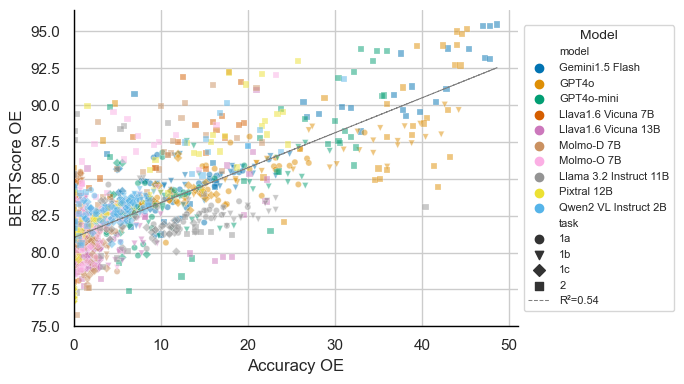

In [127]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

sns.set(style="whitegrid", palette="colorblind")
plt.figure(figsize=(7, 4))

markers = {'1a': 'o', '1b': 'v', '1c': 'D', '2': 's'}  # 'o' = circle, 'v' = triangle, 'D' = diamond, 's' = square

scatter = sns.scatterplot(
    data=df, x='acc_oe', y='bert', hue='model', 
    style='task', markers=markers, 
    s=20, alpha=0.5
)

slope, intercept, r_value, p_value, std_err = stats.linregress(df['acc_oe'], df['bert'])
r_squared = r_value ** 2

x_vals = np.array(df['acc_oe'])
y_vals = slope * x_vals + intercept
plt.plot(x_vals, y_vals, color='grey', linestyle='--', linewidth=0.75, label=f'R²={r_squared:.2f}')

# Customizing the plot
plt.xlabel('Accuracy OE', fontsize=12)
plt.ylabel('BERTScore OE', fontsize=12)

plt.xlim(left=0.0)
plt.ylim(bottom=75.0)

ax = plt.gca()

for spine in ['top', 'bottom', 'left', 'right']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_linewidth(1.0)
    ax.spines[spine].set_color('black')

legend_model = ax.legend(title="Model", loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8, title_fontsize=10)

plt.grid(True)
sns.despine()
plt.tight_layout()
plt.show()
